In [311]:
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.utils
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
import PIL.Image
import pathlib
from tensorflow.keras.preprocessing import image




In [312]:
#EXPLORATORY ANALYSIS

In [313]:
#DATASET1 KNOWN IMAGES

LOADKNOWNIMAGES = "D:/chest_opacity_badru_dataset/dataset1/known_images/"

In [314]:
primitive_hash = list()

In [315]:
#Read all file paths for the images in the dataset1 directory

for file_path in glob.glob(LOADKNOWNIMAGES+"*.png"):
    file_name = os.path.basename(file_path)
    category = file_name.split("_")[0]
    primitive_hash.append({"category":category,"im_path":file_name})

In [316]:
df = pd.DataFrame(primitive_hash)

In [317]:
df.head

<bound method NDFrame.head of     category         im_path
0     normal    normal_0.png
1     normal    normal_1.png
2     normal   normal_10.png
3     normal  normal_101.png
4     normal  normal_102.png
..       ...             ...
710     sick     sick_94.png
711     sick     sick_96.png
712     sick     sick_97.png
713     sick     sick_98.png
714     sick     sick_99.png

[715 rows x 2 columns]>

<AxesSubplot: >

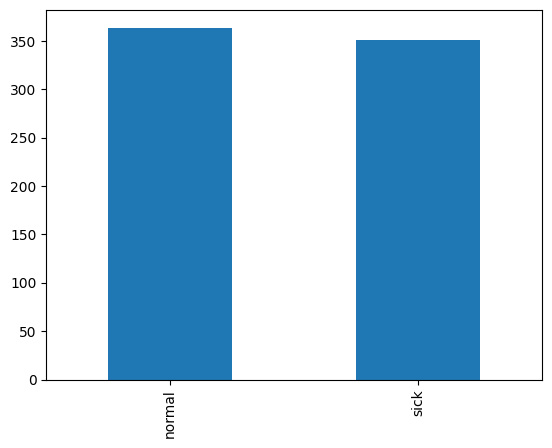

In [318]:
# Investigate class distribution, to see if there is no sample bias

df['category'].value_counts().plot(kind="bar")

In [319]:
class_names = list()
images = list()
for k in df.sample(6).itertuples():
    class_names.append(k[1])
    img = cv2.imread(LOADKNOWNIMAGES+k[2])
    images.append(img)

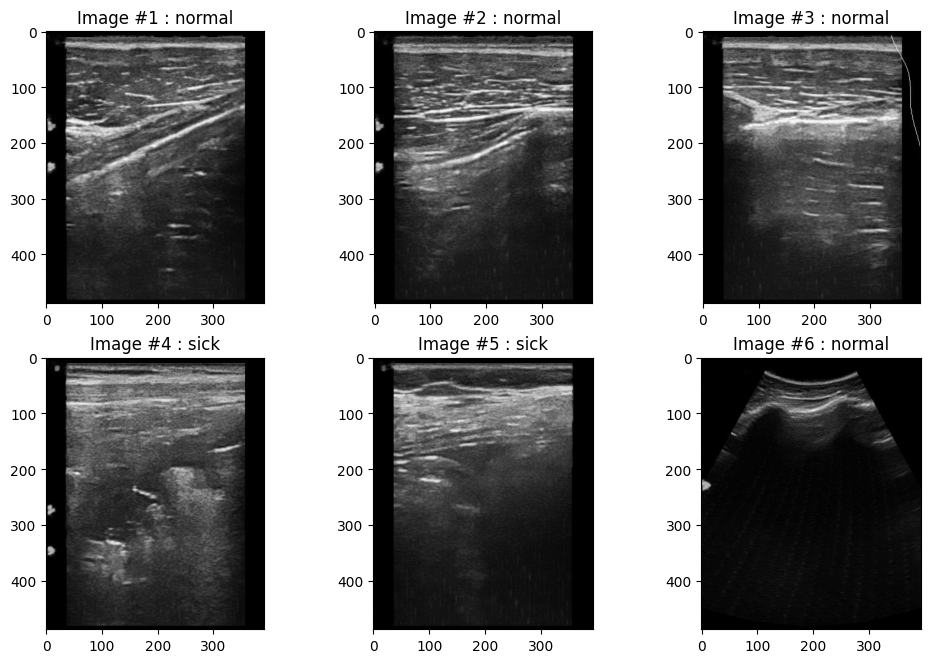

In [320]:
#Read and View a few images from the dataset

plt.figure(figsize=(12,12))
columns = 3
for i in range(6):
    plt.subplot(int(len(images)/ columns + 1), columns, i + 1)
    plt.imshow(images[i])
    plt.title('Image #{} : '.format(i+1) + class_names[i])

In [321]:
#Save dataset paths and categories #processed known data

df.to_json("D:/chest_opacity_badru_dataset/jsonfilesprocessed/known_data.json")

In [323]:
# PREPARE DATASET AND TRAIN 

import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.regularizers import l1,l2

import cv2
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from time import time
import numpy as np

In [324]:
df = pd.read_json("D:/chest_opacity_badru_dataset/jsonfilesprocessed/known_data.json")

In [325]:
df.head()

,category,im_path
0,normal,normal_0.png
1,normal,normal_1.png
2,normal,normal_10.png
3,normal,normal_101.png
4,normal,normal_102.png


In [326]:
LOADKNOWNIMAGES = "D:/chest_opacity_badru_dataset/dataset1/known_images/"

In [327]:
lbr = preprocessing.LabelBinarizer().fit(df.category)

In [328]:
import pickle

In [329]:
with open('binarizer', 'wb') as handle:
    pickle.dump(lbr,handle)

In [330]:
df['label'] = lbr.transform(df.category)

In [331]:
new_df = df.copy()

In [332]:
new_df.drop("category",axis=1,inplace=True)

In [333]:
new_df

,im_path,label
0,normal_0.png,0
1,normal_1.png,0
2,normal_10.png,0
3,normal_101.png,0
4,normal_102.png,0
...,...,...
710,sick_94.png,1
711,sick_96.png,1
712,sick_97.png,1
713,sick_98.png,1


In [129]:
train, valid = train_test_split(new_df, test_size=0.2, random_state=1)

In [334]:
train

,im_path,label
1205,sick_222.png,1
1796,sick_10.png,1
104,normal_196.png,0
1728,normal_58.png,0
736,normal_118.png,0
...,...,...
960,normal_328.png,0
905,normal_276.png,0
1096,sick_114.png,1
235,normal_318.png,0


In [335]:
train_data = {"features":[],"labels":[]}
test_data = {"features":[],"lables":[]}

In [336]:
def read_img(file_path:str):
    img_gray = cv2.imread(LOADKNOWNIMAGES+file_path,cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(img_gray, (128,128), interpolation = cv2.INTER_AREA)
    im_bw = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)[1]
    return im_bw

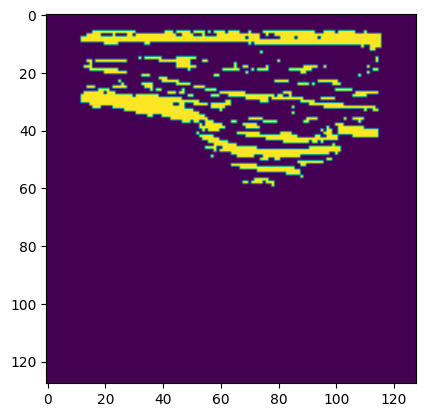

In [337]:
import matplotlib.pyplot as plt

plt.imshow(read_img("normal_22.png"))

In [338]:
train_data['labels'] = train['label']


In [339]:
train_data['features'] = train.im_path.apply(lambda x: read_img(x))

In [340]:
test_data['lables'] = valid['label']

In [341]:
test_data['features'] = valid.im_path.apply(lambda x: read_img(x))

In [342]:
X_features = []
for i in train_data['features']:
    k = i.reshape((i.shape[0], i.shape[1], 1))
    X_features.append(k)

In [343]:
X_features = np.stack(X_features, axis=0)

In [344]:
X_features.shape

(1716, 128, 128, 1)

In [345]:
X_labels = []
for i in train_data['labels']:
    X_labels.append(i)

In [346]:
X_labels = np.reshape(X_labels, (len(X_labels),-1))

In [347]:
Y_features = []
for i in test_data['features']:
    k = i.reshape((i.shape[0], i.shape[1], 1))
    Y_features.append(k)

In [348]:
Y_features = np.stack(Y_features,axis=0)

In [349]:
Y_labels = []
for i in test_data['lables']:
    Y_labels.append(i)

In [350]:
Y_labels = np.reshape(Y_labels, (len(Y_labels),-1))

In [351]:
model = Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(128,128,1),
                        kernel_regularizer=l2(0.0001)))
model.add(layers.AveragePooling2D())
model.add(layers.Dropout(0.52))

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu',kernel_regularizer=l1(0.1)))
model.add(layers.AveragePooling2D())
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu',kernel_regularizer=l1(0.1)))
model.add(layers.Dropout(0.12))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=1, activation = 'sigmoid'))

In [352]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 6)       60        
                                                                 
 average_pooling2d_4 (Avera  (None, 63, 63, 6)         0         
 gePooling2D)                                                    
                                                                 
 dropout_6 (Dropout)         (None, 63, 63, 6)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 16)        880       
                                                                 
 average_pooling2d_5 (Avera  (None, 30, 30, 16)        0         
 gePooling2D)                                                    
                                                                 
 dropout_7 (Dropout)         (None, 30, 30, 16)       

In [353]:
bce = keras.losses.BinaryCrossentropy(from_logits=False)

In [354]:
from tensorflow.keras.optimizers import Adam

In [355]:
from tensorflow import keras

In [356]:

# compile the model
model.compile(loss='bce', optimizer='adam', metrics=['accuracy'])

In [357]:
EPOCHS = 18
BATCH_SIZE = 30

In [358]:
train_generator = ImageDataGenerator(shear_range=0.72,
        zoom_range=0.72,horizontal_flip=True).flow(X_features, X_labels, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(Y_features, Y_labels, batch_size=BATCH_SIZE)

In [359]:
steps_per_epoch = X_features.shape[0]//BATCH_SIZE
validation_steps = Y_features.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
history= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

Epoch 1/18
57/57 [==============================] - 18s 278ms/step - loss: 342.9253 - accuracy: 0.6744 - val_loss: 44.1654 - val_accuracy: 0.6214
Epoch 2/18
57/57 [==============================] - 11s 188ms/step - loss: 31.7766 - accuracy: 0.6584 - val_loss: 27.0260 - val_accuracy: 0.8119
Epoch 3/18
57/57 [==============================] - 9s 165ms/step - loss: 25.1246 - accuracy: 0.7260 - val_loss: 24.0391 - val_accuracy: 0.7143
Epoch 4/18
57/57 [==============================] - 9s 162ms/step - loss: 23.0659 - accuracy: 0.7515 - val_loss: 22.4589 - val_accuracy: 0.6810
Epoch 5/18
57/57 [==============================] - 11s 184ms/step - loss: 21.6442 - accuracy: 0.7515 - val_loss: 21.6519 - val_accuracy: 0.7190
Epoch 6/18
57/57 [==============================] - 12s 200ms/step - loss: 20.8907 - accuracy: 0.7604 - val_loss: 20.3832 - val_accuracy: 0.8310
Epoch 7/18
57/57 [==============================] - 11s 181ms/step - loss: 20.1109 - accuracy: 0.7693 - val_loss: 19.7355 - val_acc

In [369]:
model.save("D:/chest_opacity_badru_dataset/lenet-95")

INFO:tensorflow:Assets written to: D:/chest_opacity_badru_dataset/lenet-95\assets


INFO:tensorflow:Assets written to: D:/chest_opacity_badru_dataset/lenet-95\assets


In [370]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [371]:
y_pred = model.predict(Y_features)

14/14 [==============================] - 1s 79ms/step


In [372]:
y_pred = list(map(lambda x: 0 if x<0.5 else 1, y_pred))

In [373]:
precision_score(Y_labels,y_pred)

0.9504132231404959

In [377]:
recall_score(Y_labels,y_pred)

0.5373831775700935

In [378]:
accuracy_score(Y_labels,y_pred)

0.7552447552447552

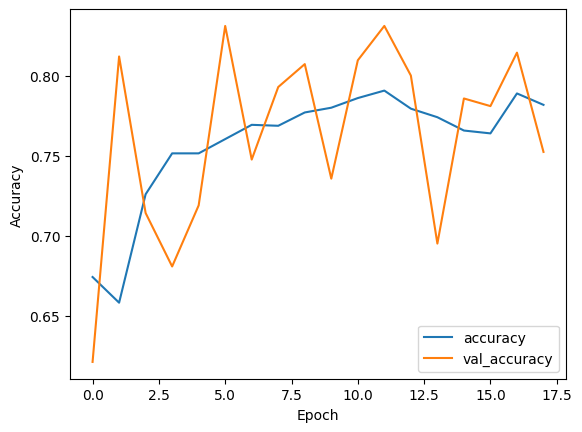

In [379]:
# Visualization of training accuracy and loss curves
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

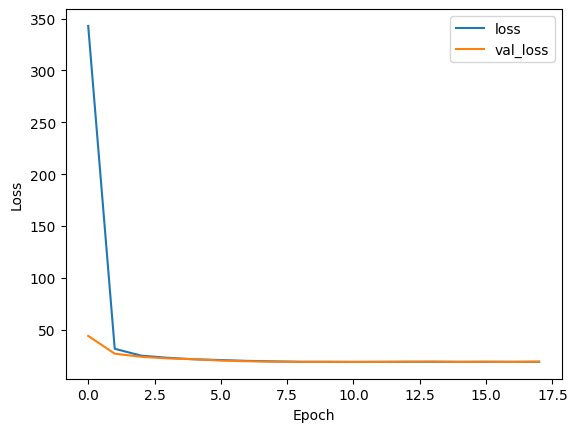

In [380]:
# Visualization of the training accuracy and loss curves
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [381]:
#DATASET1 UNKNOWN IMAGES
#Using the model to predict each class of the unknown images


import keras
import pickle
import cv2
import glob
import os
import numpy as np

In [382]:
LOADUNKNOWNIMAGES = "D:/chest_opacity_badru_dataset/dataset1/unknown_images/"

In [383]:
primitive_hash = list()

In [384]:
for file_path in glob.glob(LOADUNKNOWNIMAGES+"*.png"):
    file_name = os.path.basename(file_path)
    primitive_hash.append({"im_path":file_name})

In [385]:
df = pd.DataFrame(primitive_hash)

In [386]:
df.head()

,im_path
0,1.png
1,10.png
2,11.png
3,12.png
4,13.png


In [387]:
test_data = {"features":[],"lables":[]}

In [388]:
def read_img(file_path:str):
    img_gray = cv2.imread(LOADUNKNOWNIMAGES+file_path,cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(img_gray, (128,128), interpolation = cv2.INTER_AREA)
    im_bw = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)[1]
    return im_bw

In [389]:
test_data["features"] = df.im_path.apply(lambda x: read_img(x))

In [390]:
Y_features = []
for i in test_data['features']:
    k = i.reshape((i.shape[0], i.shape[1], 1))
    Y_features.append(k)

In [391]:
Y_features = np.stack(Y_features, axis=0)

In [392]:
Y_features.shape

(50, 128, 128, 1)

In [393]:
model = keras.models.load_model("D:/chest_opacity_badru_dataset/lenet-95")

In [394]:
y_pred = model.predict(Y_features)

2/2 [==============================] - 0s 39ms/step


In [395]:
y_pred = list(map(lambda x: 0 if x<0.5 else 1, y_pred))

In [396]:
with open('binarizer', 'rb') as handle:
    lbr = pickle.load(handle)

In [397]:
df['category'] = lbr.inverse_transform(np.array(y_pred))

In [302]:
df

,im_path,category
0,1.png,sick
1,10.png,sick
2,11.png,normal
3,12.png,sick
4,13.png,normal
5,14.png,sick
6,15.png,normal
7,16.png,sick
8,17.png,sick
9,18.png,sick


In [401]:
#processed unknown data

df.to_json("D:/chest_opacity_badru_dataset/jsonfilesprocessed/unknown_data.json")

In [402]:
#Saving the predictions for each image in a csv

df.to_csv("D:/chest_opacity_badru_dataset/unknown_data_predictions.csv")

In [427]:
# DATASET2
#Testing the model on dataset2 to determine the generalisation of the model

import pandas as pd
import cv2
import numpy as np
from sklearn.metrics import precision_score,recall_score,accuracy_score
from keras.models import load_model

In [434]:
DATASETTWOIMAGES = "D:/chest_opacity_badru_dataset/dataset2/images/"

In [435]:
primitive_hash = list()

In [436]:
#Read all file paths for the images in the dataset2 directory

for file_path in glob.glob(DATASETTWOIMAGES+"*.png"):
    file_name = os.path.basename(file_path)
    category = file_name.split("_")[0]
    primitive_hash.append({"category":category,"im_path":file_name})

In [437]:
df = pd.DataFrame(primitive_hash)

In [438]:
df.head

<bound method NDFrame.head of     category          im_path
0       sick    sick_eff0.png
1       sick    sick_eff1.png
2       sick   sick_eff10.png
3       sick  sick_eff100.png
4       sick  sick_eff101.png
..       ...              ...
219     sick   sick_eif95.png
220     sick   sick_eif96.png
221     sick   sick_eif97.png
222     sick   sick_eif98.png
223     sick   sick_eif99.png

[224 rows x 2 columns]>

In [439]:
test_data = {"features":[],"lables":[]}

In [440]:
def read_img(file_path:str):
    img_gray = cv2.imread(DATASETTWOIMAGES+file_path,cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(img_gray, (128,128), interpolation = cv2.INTER_AREA)
    im_bw = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)[1]
    return im_bw

In [441]:
test_data["features"] = df.im_path.apply(lambda x: read_img(x))

In [442]:
Y_features = []
for i in test_data['features']:
    k = i.reshape((i.shape[0], i.shape[1], 1))
    Y_features.append(k)

In [443]:
Y_features = np.stack(Y_features, axis=0)

In [444]:
Y_features.shape

(224, 128, 128, 1)

In [445]:
model = keras.models.load_model("D:/chest_opacity_badru_dataset/lenet-95")

In [446]:
y_pred = model.predict(Y_features)

7/7 [==============================] - 1s 146ms/step


In [447]:
y_pred = list(map(lambda x: 0 if x<0.5 else 1, y_pred))

In [448]:
with open('binarizer', 'rb') as handle:
    lbr = pickle.load(handle)

In [449]:
df['category'] = lbr.inverse_transform(np.array(y_pred))

In [450]:
df.head()

,category,im_path
0,normal,sick_eff0.png
1,sick,sick_eff1.png
2,sick,sick_eff10.png
3,sick,sick_eff100.png
4,sick,sick_eff101.png


In [451]:
#Saving the predictions for each image in dataset2 in a csv

df.to_csv("D:/chest_opacity_badru_dataset/unknown_data_predictions_datasettwo.csv")

In [452]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

y_pred = model.predict(Y_features)

7/7 [==============================] - 0s 47ms/step


In [453]:
y_pred = list(map(lambda x: 0 if x<0.5 else 1, y_pred))

In [454]:
precision_score(Y_labels,y_pred)

0.5811965811965812

In [455]:
recall_score(Y_labels,y_pred)

0.6071428571428571

In [456]:
accuracy_score(Y_labels,y_pred)

0.5848214285714286

In [ ]:
#On Dataset2, the model had Accuracy score of 58.5%, Recall of 60.7% and Precision score of 58.1% 

In [ ]:
#THE END